In [497]:
import vae
import torch
from vae import TimeseriesDataset, VAE
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import shap
from torch import nn
import matplotlib.pyplot as plt
from captum.attr import KernelShap

shap.initjs()

matplotlib is not installed so plotting is not available! Run `pip install matplotlib` to fix this.


In [498]:
data = range(30)
data = [[list(data)]] # serrated shape

data2 = [1]*30
data2 = [[data2]] # uniform

transform = lambda x: torch.tensor(x).float()
train_dataset = TimeseriesDataset(data, transform)
train_dataloader = DataLoader(train_dataset, batch_size=1)

test_dataset = TimeseriesDataset(data2, transform)
test_dataloader = DataLoader(test_dataset, batch_size=1)

print("Creating VAE...")
vae = VAE(input_dim=30, seq_len=1, z_units=5)
print("Successfuly created VAE")

Creating VAE...
Successfuly created VAE


In [499]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-1)

for x in train_dataloader:
    normal_data = x

vae.train(True)
for i in range(500):
        vae(normal_data)
        loss = vae.loss()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print(loss)

tensor(0.0002, grad_fn=<AddBackward0>)


In [505]:
vae.train(False)
for x in test_dataloader:
    fault_data = x

fault_data_recon = vae(fault_data)
recon_err = torch.linalg.norm(fault_data - fault_data_recon, axis=1) # different then loss, no kl divergence
fault_data_recon_abs = torch.abs(fault_data_recon)
values, indices = torch.topk(fault_data_recon_abs, 5)

print(values, indices)

for feature_idx in indices[0][0]:
    feature_idx = int(feature_idx)
    weight_save = vae.enc1.weight_ih_l0.clone()

    # Remove marginal contribution of feature_idx to vae
    vae.enc1.weight_ih_l0[:, feature_idx] = 0
    explainer = KernelShap(vae)
    shap_values = explainer.attribute(fault_data, baselines=normal_data, target=(0,feature_idx))
    vae.enc1.weight_ih_l0 = nn.Parameter(weight_save)
    print(shap_values[0, 0, indices])

recon_contribution = recon_err
print(recon_contribution)
#shap.force_plot(explainer.expected_value, shap_values[0,:])

tensor([[[28.9944, 27.9950, 26.9983, 26.0019, 25.0024]]],
       grad_fn=<TopkBackward>) tensor([[[29, 28, 27, 26, 25]]])
tensor([[[-0.0066,  0.0046, -0.0296,  0.0130,  0.0099]]])
tensor([[[ 0.0175,  0.0057, -0.0017,  0.0204, -0.0054]]])
tensor([[[ 0.0105, -0.0077, -0.0106, -0.0001,  0.0324]]])
tensor([[[ 0.0105,  0.0056,  0.0010,  0.0184, -0.0075]]])
tensor([[[-0.0041,  0.0088,  0.0104,  0.0012,  0.0034]]])
tensor([[1.0750e+00, 1.5201e-02, 9.6443e-01, 2.0078e+00, 3.0015e+00, 3.9975e+00,
         5.0027e+00, 6.0003e+00, 7.0046e+00, 8.0075e+00, 9.0096e+00, 1.0009e+01,
         1.1007e+01, 1.1999e+01, 1.2998e+01, 1.3990e+01, 1.4999e+01, 1.6001e+01,
         1.7004e+01, 1.8008e+01, 1.9007e+01, 2.0006e+01, 2.1006e+01, 2.2007e+01,
         2.3005e+01, 2.4002e+01, 2.5002e+01, 2.5998e+01, 2.6995e+01, 2.7994e+01]],
       grad_fn=<CopyBackwards>)


In [421]:
class lstm(nn.Module):
    def __init__(self):
        super(lstm, self).__init__()
        self.lstm = nn.LSTM(
                    input_size=5,
                    hidden_size=5,
                    num_layers=1,
                    batch_first=True
                )
        self.loss_fn = nn.L1Loss()
    def forward(self, x):
        self.input = x
        self.output, _ = self.lstm(x)
        return self.output
    def loss(self):
        return self.loss_fn(self.input, self.output)

def scale_down(x):
    return (x-2.5)*(1/5)

def scale_up(x):
    return x*5+2.5

In [391]:
data = [[[1]+[5]*4],[[2]+[5]*4],[[3]+[5]*4],[[4]+[5]*4],[[5]+[5]*4]]

toy_lstm = lstm()

transform = lambda x: scale_down(torch.tensor(x).float())
dataset = TimeseriesDataset(data, transform)
dataloader = DataLoader(dataset, batch_size=1)

optimizer_lstm = torch.optim.Adam(toy_lstm.parameters(), lr=1e-2)

losses = []
toy_lstm.train(True)
for i in range(50):
    for d in dataloader:
        x = d
        out = toy_lstm(d)
        loss = toy_lstm.loss()
        losses.append(loss)
        optimizer_lstm.zero_grad()
        loss.backward()
        optimizer_lstm.step()

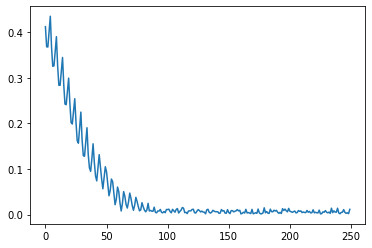

In [369]:
plt.plot(losses)
plt.show()

In [396]:
datum = torch.tensor([[range(5)]], dtype=torch.float)
datum = scale_down(datum)
prezero = toy_lstm(datum)
for w in toy_lstm.parameters():
    print(w.shape)

weight_save = toy_lstm.lstm.weight_ih_l0.clone()
toy_lstm.lstm.weight_ih_l0[:,0] = 0
postzero = toy_lstm(datum)
prezero = scale_up(prezero)
postzero = scale_up(postzero)
print(prezero, '\n', postzero, '\n', prezero-postzero)
toy_lstm.lstm.weight_ih_l0 = nn.Parameter(weight_save)

torch.Size([20, 5])
torch.Size([20, 5])
torch.Size([20])
torch.Size([20])
tensor([[[0.3717, 3.8022, 4.3720, 3.9179, 4.4211]]], grad_fn=<AddBackward0>) 
 tensor([[[0.8843, 3.8160, 4.3455, 3.9810, 4.4731]]], grad_fn=<AddBackward0>) 
 tensor([[[-0.5126, -0.0138,  0.0265, -0.0630, -0.0520]]],
       grad_fn=<SubBackward0>)


In [342]:
x = torch.tensor([[[5,5]]]).float()
out = toy_lstm(x)
print(x, out)
print(x-out)

RuntimeError: input.size(-1) must be equal to input_size. Expected 5, got 2

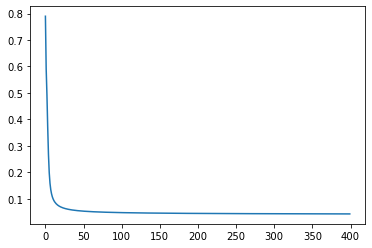

In [310]:
lstm_1 = nn.LSTM(3, 3)

in_tensor = torch.Tensor([[-1,0,1]]).reshape(1,1,3)

optimizer = torch.optim.Adagrad(lstm_1.parameters(), lr=2e-1, lr_decay=0.02)
loss_fn = nn.MSELoss()


losses = []
for i in range(400):
    pred_out = lstm_1(in_tensor)[0]
    optimizer.zero_grad()
    loss = loss_fn(pred_out, in_tensor)
    losses.append(loss)
    loss.backward()
    optimizer.step()

plt.plot(losses)
plt.show()


In [311]:
print(in_tensor.shape)
print(lstm_1(in_tensor)[0])

torch.Size([1, 1, 3])
tensor([[[-0.7458,  0.0000,  0.7440]]], grad_fn=<StackBackward>)
